In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [2]:

df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/ADP_SONY/ADP_34/data/m2_source.csv')
df.head(4)

,일자,자원,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_24
0,2021-01-01,태양광,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.07,...,22.62,15.22,8.02,1.89,0.10,0.81,0.11,0.01,0.01,0.01
1,2021-01-01,풍력,119.64,105.18,106.19,76.71,65.16,79.13,47.67,39.37,...,29.19,27.11,23.78,19.02,36.62,24.00,19.66,14.78,23.45,21.14
2,2021-01-02,태양광,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.13,...,109.39,76.44,30.46,6.49,4.43,3.87,1.45,0.84,0.13,0.01
3,2021-01-02,풍력,36.33,54.85,68.76,59.23,61.03,85.77,75.80,64.57,...,83.97,125.86,154.00,157.83,176.06,172.67,143.09,144.29,128.74,135.89


1. 전력량 데이터에서 결측치를 제거하라.
2. 결측치가 존재하는 시간대의 동일 일자, 동일 자원 데이터의 직전 값과 다음 값의 평균으로 대치한다.
3. 연속된 시간대의 결측치가 있다면 결측치가 아닌 이전 시간대의 값과 이후 시간대의 값의 평균으로 모든 연속 시간대 결 측치를 대치한다.
4. 맨앞이나 맨뒤에 결측치가 존재한다면 직전, 직후 시간대 값으로 대치한다.

In [3]:
power = df.copy()

power['hour_1'] = power['hour_1'].fillna(power['hour_2'])
power['hour_24'] = power['hour_24'].fillna(power['hour_23']) 

# 결측치가 존재하는 시간대의 동일 일자, 동일 자원 데이터의 직전 값과 다음 값의 평균으로 대치 
mean = (power.iloc[:,2:].ffill(axis= 1) + power.iloc[:,2:].bfill(axis = 1)) / 2 
power.iloc[:,2:] = mean


In [4]:
#총 전력량
# 2. 결측치를 제거한 전력량 데이터에 대해 총전력량(태양광 + 풍력 발전량의 합)을 구한다.
#     - 동일 일자 동일 시간대에 대해 태양광과 풍력의 합을 구한다. 하나의 일자는 하나의 행에 시간대별 총전력량을 표현해야한다.
#     - 특정일자에 태양광 또는 풍력이 하나만 있는 경우에는 해당 자원의 전력량을 2배로 한다.

power_sum = power.groupby(['일자','자원']).sum().reset_index()
power_sum.head()

,일자,자원,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,hour_24
0,2021-01-01,태양광,0.00,0.00,0.000,0.00,0.01,0.00,0.00,0.07,...,22.62,15.22,8.02,1.89,0.10,0.81,0.11,0.01,0.01,0.01
1,2021-01-01,풍력,119.64,105.18,106.190,76.71,65.16,79.13,47.67,39.37,...,29.19,27.11,23.78,19.02,36.62,24.00,19.66,14.78,23.45,21.14
2,2021-01-02,태양광,0.00,0.00,0.000,0.00,0.00,0.00,0.00,0.13,...,109.39,76.44,30.46,6.49,4.43,3.87,1.45,0.84,0.13,0.01
3,2021-01-02,풍력,36.33,54.85,68.760,59.23,61.03,85.77,75.80,64.57,...,83.97,125.86,154.00,157.83,176.06,172.67,143.09,144.29,128.74,135.89
4,2021-01-03,태양광,0.04,0.01,0.005,0.00,0.03,0.02,0.00,0.40,...,90.94,43.06,18.88,7.51,5.32,6.05,3.24,1.94,0.64,0.23


In [5]:
power_pivot = power_sum.melt(id_vars = ['일자','자원'] , 
              var_name = 'hour',
              value_name = '총전력량')
power_pivot.head()

,일자,자원,hour,총전력량
0,2021-01-01,태양광,hour_1,0.00
1,2021-01-01,풍력,hour_1,119.64
2,2021-01-02,태양광,hour_1,0.00
3,2021-01-02,풍력,hour_1,36.33
4,2021-01-03,태양광,hour_1,0.04


In [6]:
# 특정일자에 태양광 또는 풍력이 하나만 있는 경우에는 해당 자원의 전력량을 2배로 
# Groupby 로 nunique()가 1인 날짜 인덱스만 추출 
indx = power_pivot.groupby('일자')['자원'].nunique() == 1
one_day = indx[indx].index

# 자원이 하나면 2배 처리 
power_pivot.loc[power_pivot['일자'].isin(one_day) ,'총전력량'] *= 2 

In [7]:
power_group = power_pivot.groupby(['일자','hour'])['총전력량'].sum().reset_index()
power_group['hour'] = power_group['hour'].astype(str).str.split('_').str[1].str.zfill(2)
power_group['date'] = pd.to_datetime(power_group['일자'] + ' ' + (power_group['hour'].astype(int) - 1).astype(str) ,  format = '%Y-%m-%d %H' )
power_group = power_group.sort_values('date')

# season 생성
# 1,2월 제거 
filter_power = power_group[~power_group['date'].dt.month.isin([1,2])]

filter_power['season'] =  filter_power['date'].dt.month.apply(lambda x : 0 if x in [3,4,5] else 
                                                                         1 if x in [6,7,8] else 
                                                                         2) 

final_power = filter_power[['date','총전력량','season']]
final_power.head(5)

C:\Users\i2max-DoeunKim\AppData\Local\Temp\ipykernel_26104\1115110696.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_power['season'] =  filter_power['date'].dt.month.apply(lambda x : 0 if x in [3,4,5] else


,date,총전력량,season
1416,2021-03-01 00:00:00,99.59,0
1427,2021-03-01 01:00:00,112.45,0
1433,2021-03-01 02:00:00,123.76,0
1434,2021-03-01 03:00:00,126.22,0
1435,2021-03-01 04:00:00,136.05,0


In [8]:
w = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/ADP_SONY/ADP_34/data/m2_weather.csv')
w.head(3)

,일시,기온,강수량,풍속,습도,일조,일사,적설,전운량,지면온도
0,2021_01_01@0,4.5,NaN,6.1,53.0,NaN,NaN,NaN,9.0,2.2
1,2021_01_01@1,4.3,NaN,5.6,58.0,NaN,NaN,NaN,9.0,2.4
2,2021_01_01@2,4.2,NaN,5.5,54.0,NaN,NaN,NaN,10.0,2.3


In [9]:
w['일시'] = pd.to_datetime(w['일시'].str.replace('_','-').str.replace('@',' ') ,format = '%Y-%m-%d %H' ) 

In [10]:
# 기상데이터 결측치 처리
# 5. 기상데이터의 결측치를 처리한다
#     - 강수량, 일조, 일사, 적설은 0으로 채운다.
#     - 풍속, 습도는 직전값으로 전운량과 지면온도는 전체 평균값으로 대치한다. + 기온도 직전값 

fw = w.copy()
for col in fw.columns : 
    if col in ['강수량','일조','일사','적설'] :
        fw[col] = fw[col].fillna(0) 
    elif col in ['풍속','습도','기온'] : 
        fw[col] = fw[col].ffill() 
    elif col in ['전운량','지면온도'] : 
        fw[col] = fw[col].fillna(fw[col].mean()) 

In [11]:
m_df = pd.merge(final_power, fw, how = 'left' , left_on = 'date', right_on = '일시').drop(columns = 'date')
m_df.head()

,총전력량,season,일시,기온,강수량,풍속,습도,일조,일사,적설,전운량,지면온도
0,99.59,0,2021-03-01 00:00:00,16.6,0.0,4.6,73.0,0.0,0.0,0.0,6.0,12.3
1,112.45,0,2021-03-01 01:00:00,17.6,0.0,5.1,68.0,0.0,0.0,0.0,10.0,12.8
2,123.76,0,2021-03-01 02:00:00,17.6,0.0,4.7,67.0,0.0,0.0,0.0,9.0,12.6
3,126.22,0,2021-03-01 03:00:00,17.9,0.0,4.6,66.0,0.0,0.0,0.0,9.0,12.5
4,136.05,0,2021-03-01 04:00:00,18.8,0.0,6.2,63.0,0.0,0.0,0.0,9.0,12.5


##### 2.2 전처리 완료된 데이터의 기술 통계량 및 EDA를 실시하라 (시각화 포함)

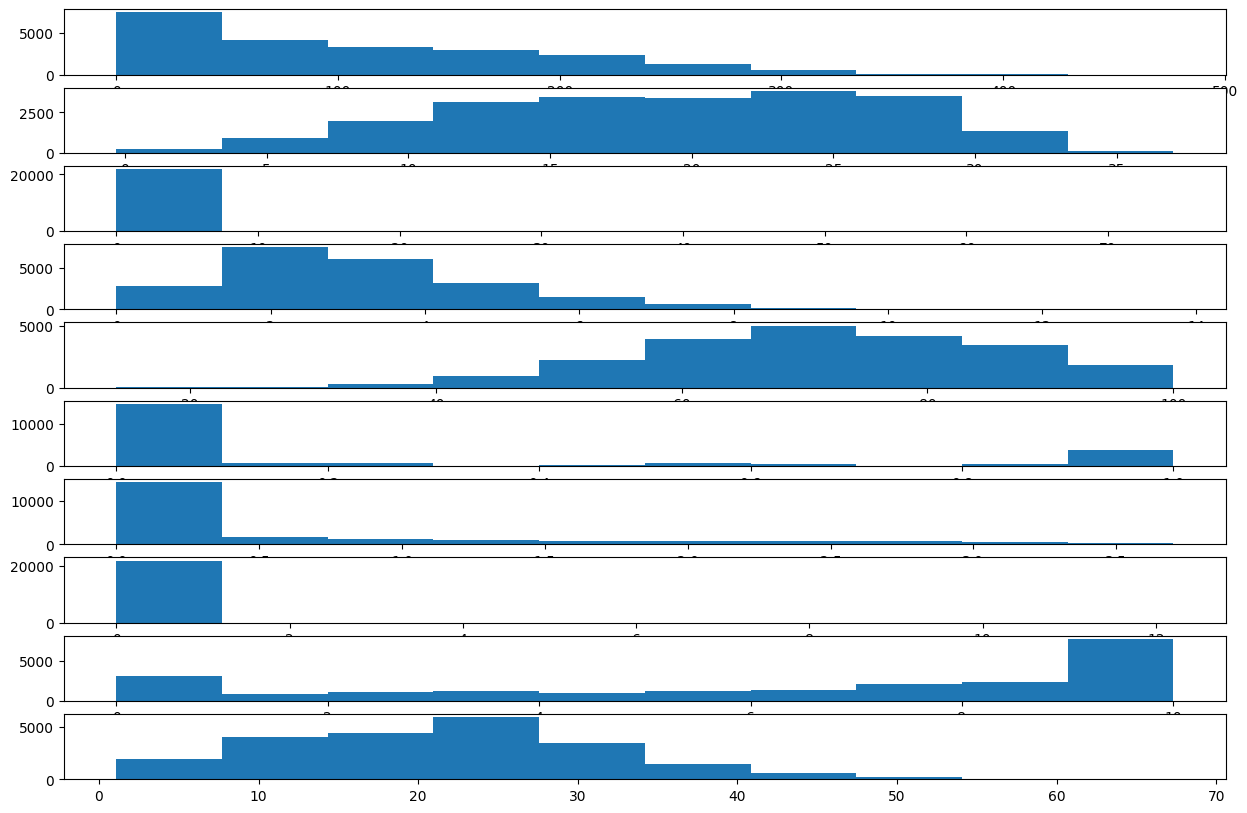

<Figure size 640x480 with 0 Axes>

In [12]:
cols = ['총전력량',  '기온', '강수량', '풍속','습도', '일조', '일사', '적설',  '전운량', '지면온도']

fig, axes = plt.subplots(10, 1, figsize = (15, 10))
for axes , c in zip(axes.flatten(), m_df[cols].columns) : 
    axes.hist(m_df[c])

plt.show()
plt.tight_layout()


2-3
- 총전력량을 종속변수로 하고 종속변수와 다른 연속형 변수들간의 상관관계 분석을 진행하라. 유의확률을 포함하여 분석결과를 서술하라.
- season에 따라 종속변수간의 차이가 있는지 통계적으로 확인하고 분석결과를 서술하라

In [23]:
# 총전력과, 다른 연속형 변수 상관관계 
from scipy.stats import pearsonr , f_oneway
X = m_df.drop(columns = ['총전력량','season','일시'], axis = 1)
y = m_df['총전력량']

In [19]:
res = []
for x in X.columns : 
    cor, p_val = pearsonr(m_df[x] , y) 
    decision = '유의하다' if p_val < 0.05 else '유의하지 않다'
    res.append([x , cor, p_val, decision])

pd.DataFrame(res)

,0,1,2,3
0,기온,0.012500,6.353797e-02,유의하지 않다
1,강수량,-0.005195,4.406898e-01,유의하지 않다
2,풍속,0.515133,0.000000e+00,유의하다
3,습도,-0.338387,0.000000e+00,유의하다
4,일조,0.508636,0.000000e+00,유의하다
5,일사,0.629051,0.000000e+00,유의하다
6,적설,0.008620,2.007346e-01,유의하지 않다
7,전운량,-0.028286,2.679824e-05,유의하다
8,지면온도,0.236017,1.488140e-276,유의하다


4.50618661623794e-51
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     0      1 -20.2194    0.0 -23.6481 -16.7907   True
     0      2     -2.6 0.1393   -5.811    0.611  False
     1      2  17.6194    0.0  14.4084  20.8304   True
------------------------------------------------------


<Figure size 800x600 with 0 Axes>

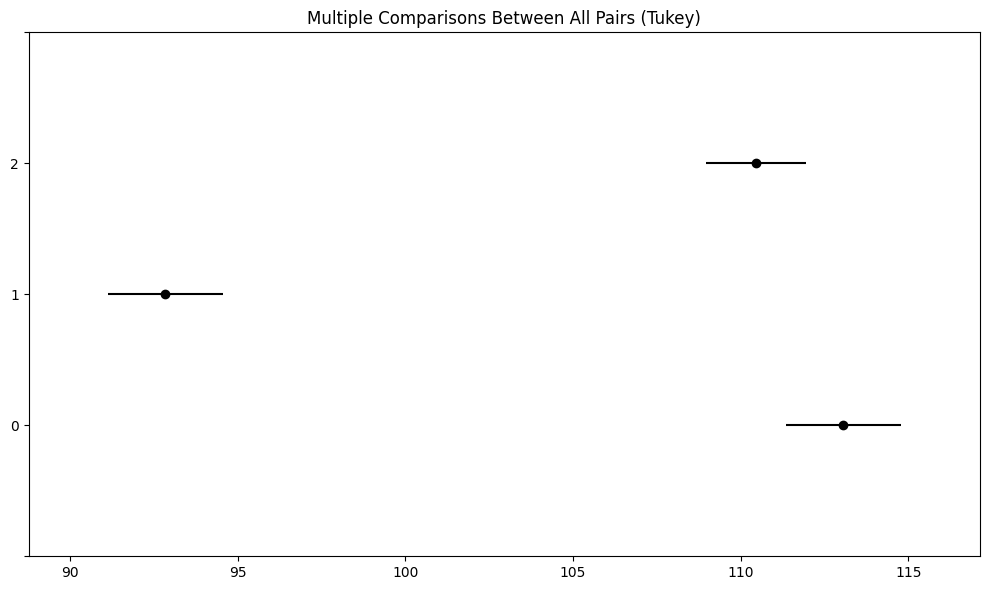

In [32]:
# season에 따라 종속변수간의 차이가 있는지 통계적으로 확인하고 분석결 
# 귀무가설 : 전력량은 같다
# 대립가설 : 전력량은 다르디 

group = [ group for name, group in m_df.groupby('season')['총전력량'] ]

stats, p_val = f_oneway(*group)
print(p_val) 

from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog = m_df['총전력량'] , groups = m_df['season'])
print(tukey)
plt.figure(figsize=(8,6))
tukey.plot_simultaneous()
plt.tight_layout()
plt.show()

2-4 아래 기준으로 회귀모델링을 진행하고 평가하라.

- 21년,22년도를 학습데이터, 23년도를 평가데이터로 사용한다.
- RMSE를 포함한 적절한 평가지표 2가지로 판단
- 일반 회귀모형 1개, 기계학습 모델 1개로 진행한다.

3-1. 성별,교육방법에 따른 성적의 차이가 존재하는지 확인하려한다. 가설 검정 전 필요한 사전 가정을 설명하고 확인하라.

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/doeungim/ADP_DE2/refs/heads/main/ADP_SONY/ADP_34/data/student_scores.csv')
df.head()

# 각 하나의 id에 3가지의 성적 점수가 존재 
# 동일 학생에게 3개의 교육방법을 적용 >> 반복 측정 

,id,성별,traindition,online,mix
0,1,Male,69,74,68
1,2,Male,59,65,63
2,3,Male,60,75,63
3,4,Male,79,52,76
4,5,Male,100,77,67


In [6]:
# 정규성과 등분산성을 검토하기 위해서는 반드시 피벗팅 해야한다. 

df.melt(id_vars = ['id','성별'] , 
       value_vars = ['traindition','online','mix'] ,
       var_name = '교육방법', 
       value_name = '점수')

,id,성별,교육방법,점수
0,1,Male,traindition,69
1,2,Male,traindition,59
2,3,Male,traindition,60
3,4,Male,traindition,79
4,5,Male,traindition,100
...,...,...,...,...
115,36,Female,mix,76
116,37,Female,mix,73
117,38,Female,mix,68
118,39,Female,mix,63
